In [2]:
import gym
import numpy as np
import os

# Common imports
import numpy as np
import random
import os
import collections

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

env = gym.make('CartPole-v1')

## Visualize Actions / Observations

In [3]:
def record_scenario(env, policy, num_frames=500) -> dict:
    frames = []
    obs_mat = np.empty((num_frames, 4))
    actions = np.empty((num_frames,))
    rewards = np.empty((num_frames,))
    dones = np.empty((num_frames,), dtype=int)
    first_done_info = ''
    obs = env.reset()  # initial observation
    for i in range(num_frames):
        action = policy(obs)
        obs_mat[i,:] = obs
        obs, reward, done, info = env.step(action)
        img = env.render(mode="rgb_array")
        frames.append(img)
        actions[i] = action
        rewards[i] = reward
        dones[i] = int(done)
        if done and first_done_info == '':
            first_done_info = info
    record = {'frames': frames, 'obs': obs_mat, 'actions': actions, 'rewards': 
              rewards, 'dones': dones, 'first_done_info':first_done_info}
    return record

def record_data(env, policy, num_frames=500):
    obs_mat = np.empty((num_frames, 4))
    actions = np.empty((num_frames,))
    rewards = np.empty((num_frames,))
    dones = np.empty((num_frames,), dtype=int)
    first_done_info = ''
    obs = env.reset()  # initial observation
    for i in range(num_frames):
        action = policy(obs)
        obs_mat[i,:] = obs
        obs, reward, done, info = env.step(action)
        actions[i] = action
        rewards[i] = reward
        dones[i] = int(done)
        if done and first_done_info == '':
            first_done_info = info
    record = {'obs': obs_mat, 'actions': actions, 'rewards': 
              rewards, 'dones': dones, 'first_done_info':first_done_info}
    return record

In [4]:
def update_scene(num, frames, patch, time_text, obs_mat, actions, cum_rewards, dones):
    patch.set_data(frames[num])
    text = f"frame: {num}"
    text += ", Obs: ({:.3f}, {:.3f}, {:.3f}, {:.3f})\n".format(*obs_mat[num,:])
    text += f"Action: {actions[num]}"
    text += f", Cumulative Reward: {cum_rewards[num]}"
    text += f", Done: {dones[num]}"
    time_text.set_text(text)
    return patch, time_text

def plot_animation(record, repeat=False, interval=40):
    '''record should contain
    frames: list of N frames
    obs: (N, 4) array of observations
    actions: (N, ) array of actions {0, 1}
    rewards: (N, ) array of rewards at each step {0, 1}
    dones: (N, 1) array of dones {0, 1}
    '''
    cum_rewards = np.cumsum(record['rewards'])
    frames = record['frames']
    fig = plt.figure()
    patch = plt.imshow(record['frames'][0])
    ax = plt.gca()
    time_text = ax.text(0., 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch, time_text, record['obs'], record['actions'], cum_rewards, record['dones']),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

## Policy

In [5]:
N_scenario = 1000
MAX_ACTIONS = 500

def test_policy(policy_func, n_scenario = N_scenario, max_actions = MAX_ACTIONS, verbose=False):
    final_rewards = []
    for episode in range(n_scenario):
        if verbose and episode % 50 == 0:
            print(episode)
        episode_rewards = 0
        obs = env.reset()  # reset to a random position
        for step in range(max_actions):
            action = policy_func(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards += reward
            if done:
                break
        final_rewards.append(episode_rewards)
    return final_rewards

In [6]:
def plot_policy(final_rewards, policy_name:str=''):
    fig = plt.plot(range(len(final_rewards)), final_rewards)
    plt.grid()
    plt.title(policy_name + " Mean Reward {:.2f}, Std Reward {:.2f}".format(np.mean(final_rewards), np.min(final_rewards)))
    plt.ylabel('Cum Reward')
    plt.xlabel('Iteration')
    plt.ylim(0, max(final_rewards)*1.1)
    return fig

### Combines policy

In [7]:
def theta_omega_policy(obs):
    theta, w = obs[2:4]
    if abs(theta) < 0.03:
        return 0 if w < 0 else 1
    else:
        return 0 if theta < 0 else 1

In [8]:
env.seed(42)
random.seed(0)

# the cart-pole experiment will end if it lasts more than 500 steps, with info="'TimeLimit.truncated': True"
theta_omega_rewards = test_policy(theta_omega_policy, max_actions=510)

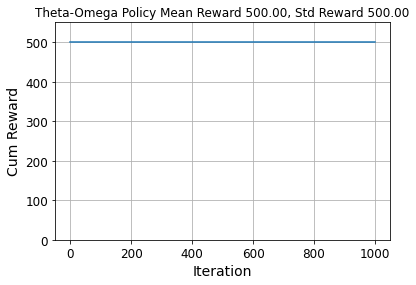

In [9]:
plot_policy(theta_omega_rewards, "Theta-Omega Policy")

In [10]:
theta_omega_record = record_data(env, theta_omega_policy, 500)

In [11]:
# plot_animation(theta_omega_record)

## Train a decision tree to learn the policy

In [127]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.neural_network import MLPClassifier
obs, actions, rewards = [], [], []

n_records = 100
for i in range(n_records):
    theta_omega_record = record_data(env, theta_omega_policy, 500)
    obs.append(theta_omega_record['obs'])
    actions.append(theta_omega_record['actions'])
    rewards.append(theta_omega_record['rewards'])

rewards = np.array(rewards).ravel()
obs = np.array(obs).reshape(n_records*500, 4)
actions = np.array(actions).ravel()


print(obs.shape)

(50000, 4)


In [13]:
clf = DecisionTreeClassifier(max_depth=4,class_weight='balanced')
dtr = DecisionTreeRegressor(max_depth=4)
lbm = LGBMRegressor()
lbc = LGBMClassifier(n_estimators=200)

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15,9), random_state=10, max_iter=100000, tol=1e-6)
clf.fit(obs, actions)
# mlp.fit(obs, actions)
dtr.fit(obs, actions)
lbm.fit(obs, actions)
lbc.fit(obs, actions)

LGBMClassifier(n_estimators=200)

In [14]:
print(f1_score(actions, clf.predict(obs)), accuracy_score(actions, clf.predict(obs)))
print(f1_score(actions, lbc.predict(obs)), accuracy_score(actions, lbc.predict(obs)))
#dtr.predict(obs)
lbc.predict(obs)

1.0 1.0
1.0 1.0


array([0., 1., 1., ..., 0., 1., 0.])

In [15]:
plt.figure(dpi=300, figsize=(4,3));
# plot_tree(clf, feature_names=['x', 'v', r'$\theta$', r'$\omega$'], class_names=["left","right"]);

<Figure size 1200x900 with 0 Axes>

In [16]:
actions[actions == 0].shape
env.seed(0)
env.reset(), env.seed(0), env.reset()

(array([-0.04456399,  0.04653909,  0.01326909, -0.02099827], dtype=float32),
 [0],
 array([-0.04456399,  0.04653909,  0.01326909, -0.02099827], dtype=float32))

## Montecarlo-like



In [94]:
obs = []
actions = []

env.seed(0)
env.reset()

step=0
while True:
    step+=1
    action = np.random.choice([0,1])
    ob, rewards, terminated, info = env.step(action)
    obs.append(ob), actions.append(action)
    if terminated: break

print(len(actions))

18


In [95]:
def explore_actions(env, change_node, actions, seed=0):
    env.seed(seed)
    env.reset()
    obs = []
    new_actions = []
    step=0
    for action in actions[:-change_node]:
        step+=1
        # action = np.random.choice([0,1])
        ob, rewards, terminated, info = env.step(action)
        obs.append(ob), new_actions.append(action)
        if terminated: break

    if not terminated:
        # print("continue to explore", len(new_actions))
        while True:
            step+=1
            action = np.random.choice([0,1])
            ob, rewards, terminated, info = env.step(action)
            obs.append(ob), new_actions.append(action)
            if terminated: break

    return new_actions, obs


# change_node=1
# best_actions = []
# while change_node<len(actions):

#     new_actions, obs = explore_actions(env, change_node, actions)
#     if len(new_actions)>len(actions):
#         print(len(new_actions), len(actions), change_node)
#         if len(new_actions)>len(best_actions):
#             best_actions=new_actions

#     change_node+=1

In [104]:
best_actions=[]
best_obs = []
for ep in range(20):
    print(f" {ep} ".center(80, '*'))
    change_node=1
    if len(actions) == 500:
        break
    if len(best_actions)>0:
        actions = best_actions
    best_actions = []
    while change_node<len(actions):
        new_actions, obs = explore_actions(env, change_node, actions)
        if len(new_actions)>len(actions):
            print(len(new_actions), len(actions), change_node)
            if len(new_actions)>len(best_actions):
                best_actions=new_actions
                # best_obs = obs
        change_node+=1
        


************************************** 0 ***************************************


In [109]:
env.seed(0)
env.reset()
obs = []
new_actions = []
step=0
for action in actions[:]:
    step+=1
    # action = np.random.choice([0,1])
    ob, rewards, terminated, info = env.step(action)
    obs.append(ob)
    if terminated: break

obs = np.array(obs)

# Train on random montecarlo search

In [121]:
clf = DecisionTreeClassifier(max_depth=20,class_weight='balanced')
clf.fit(obs, actions)

DecisionTreeClassifier(class_weight='balanced', max_depth=20)

In [122]:
accuracy_score(actions, clf.predict(obs))

1.0

(50000,)


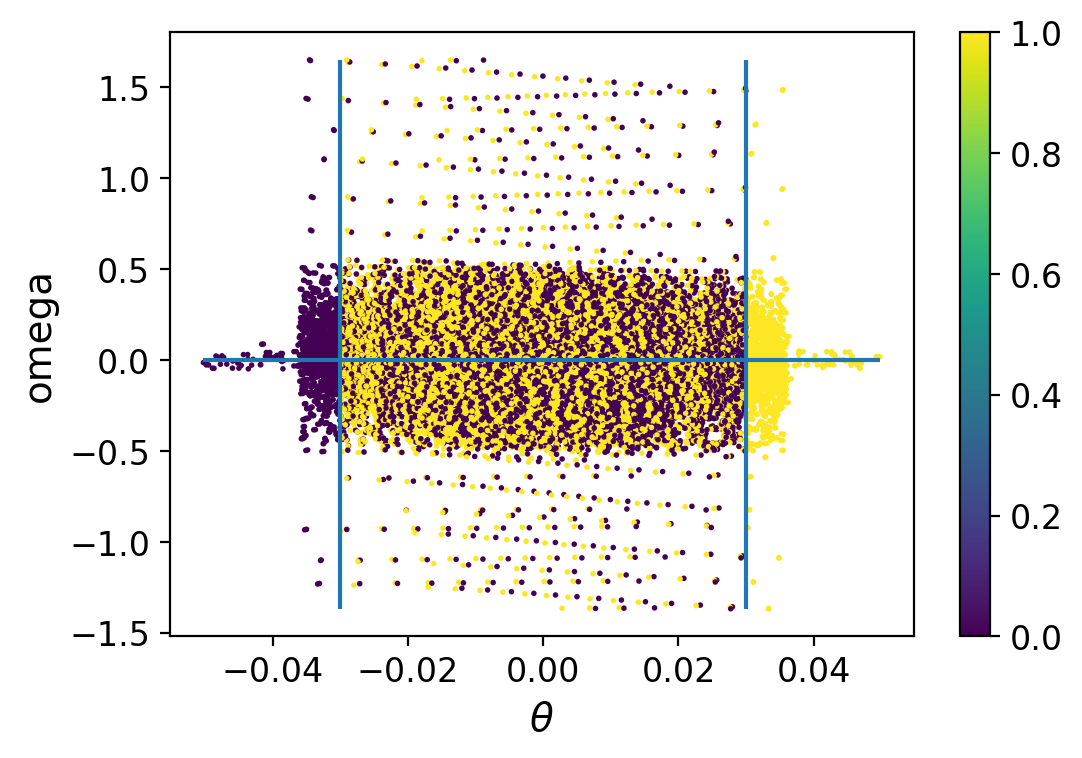

In [128]:
# color = clf.predict(obs)
color = actions
speed = obs[:, 0]
theta = obs[:, 2]
plt.figure(figsize=(6, 4), dpi=200)
plt.scatter(theta, speed, c=color, s=1), print(obs[:, 2].shape)
plt.vlines([0.03, -0.03], ymin=min(speed), ymax=max(speed))
plt.hlines([0], xmin=min(theta), xmax=max(theta))
plt.xlabel(r'$\theta$')
plt.ylabel('omega')
plt.colorbar();

0.594

500